In [9]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

import plotly.figure_factory as ff

In [10]:
trees = pd.read_csv('data/black_spruce.csv')

In [11]:
trees['status_0_1'] = (trees['status'] == 'fallen').astype(int)

In [13]:
splits=[4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20, 25, 32]
pr_split = np.zeros(len(splits)-1)
ct_split = np.zeros(len(splits)-1)

for i in range(0, len(splits)-1):
    sub_trees = trees['status_0_1'][((trees['diameter'] > splits[i]) & 
                                     (trees['diameter'] <= splits[i+1]))]
    pr_split[i] = np.mean(sub_trees)  
    ct_split[i] = len(sub_trees) 
    
tree_bins = pd.DataFrame({'proportion': pr_split, 
                          'count':ct_split, 'diameter':splits[1:]})    

In [16]:
fig = px.scatter(tree_bins, x='diameter', y='proportion', size='count', 
        labels={'diameter':"Tree Diameter (cm)", 'proportion':"Proportion Down"},
         width=450, height=250)

# Modeling Proportions (and Probabilities)

The relationship between tree diameter and the proportion of downed trees does not appear linear. In fact, if we fit a simple linear model to these data, we get several undesirable features. 

Following, the techniques of modeling from {numref}`Chapter %s <ch:linear>`, we use scikit-learn to fit a least squares linear regression model of tree status to diameter:

In [12]:
from sklearn.linear_model import LinearRegression
X = trees[['diameter']].to_numpy()
Y = trees['status_0_1'].to_numpy()

lin_reg = LinearRegression()
lin_reg.fit(X, Y)

LinearRegression()

We add this fitted line to our scatter plot of proportions: 

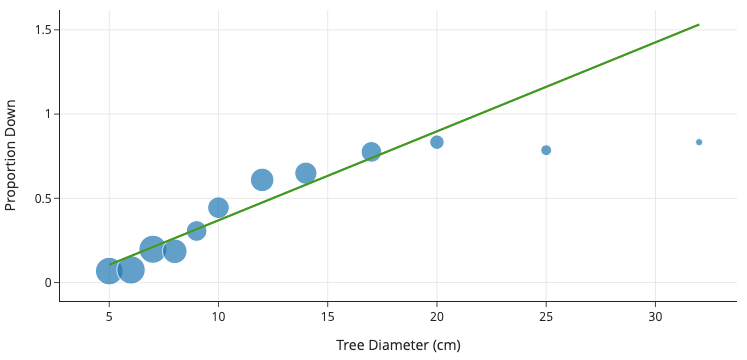

In [18]:
X_plt = np.expand_dims(np.linspace(X.min(), X.max(), 50),1)

fig.add_trace(go.Scatter(x=X_plt.flatten(), y=lin_reg.predict(X_plt),
                    mode='lines'))

fig.update_layout(showlegend=False)
fig.show()

Clearly the model doesn't fit the proportions well at all. There are several problems:

+ The model gives proportions greater than 1.
+ The model doesn't pick up the curvature in the proportions.
+ An extreme point (such as a very large tree) shift the model to the right, away from the data.  

At the very least this model should probably predict a number between zero and one. To do this, we could constrain the fitted values to be between 0 and 1. But, the other issues would not be resolved. We need a better model, such as the logistic regression model. We introduce it next.

## A Logistic Model 

The logistic model is one of the most widely used basic models for classification and a simple extension of linear models. The *logistic function*, often called the *sigmoid function*, is defined as: 

$$
\textbf{logistic}(t) = \frac{1}{1+\exp(-t)}
$$

:::{warning}

The *sigmoid* function is typically denoted by $\sigma(t)$. Sadly, the Greek letter $\sigma$ is widely used to mean a lot of things in data science, like the standard deviation, logistic function, and permutations. You will have to be careful when seeing  $ \sigma $ and guess its meaning from context. 

:::

We can plot the logistic function to reveal it's s-shape (sigmoid-shape) and confirm that it outputs numbers between 0 and 1. The function monotonically increases with $ t $, and large values of $ t $ correspond to values closer to 1.

In [19]:
def logistic(t):
    return 1. / (1. + np.exp(-t))

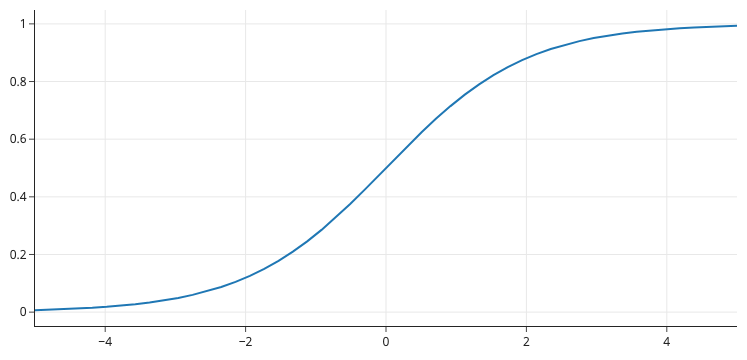

In [20]:
t = np.linspace(-5,5,50)
sigmoid_line = go.Scatter(name="Logistic Function",
    x=t, y=logistic(t), mode="lines")

fig = go.Figure([sigmoid_line])      
fig.update_layout(width=400, height=250)
fig

Since the logistic function maps to the interval between 0 and 1, it is commonly used when modeling probabilities. We can write the logistic model in the form:

$$
\sigma\left(\theta_0 + \theta_1 x\right) = \frac{1}{1+\exp(-\theta_0 - \theta_1 x)}
$$

To help build your intuition, the following plot shows the shape of the logistic function as we vary $\theta_0$ and $\theta_1$

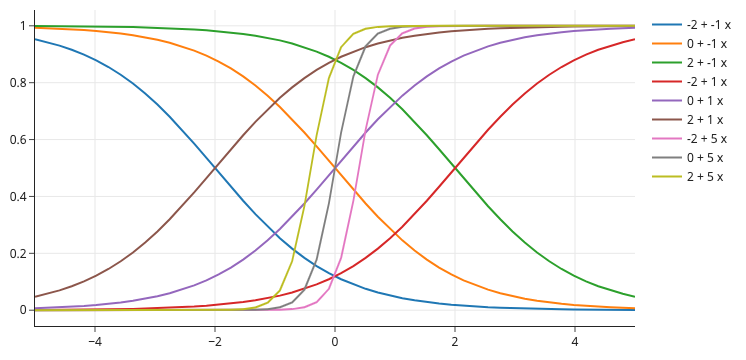

In [22]:
fig = go.Figure()
for theta1 in [-1,1, 5]:
    for theta0 in [-2, 0, 2]:
        fig.add_trace(go.Scatter(name=f"{theta0} + {theta1} x", 
                                 x=t, y=logistic(theta0 + theta1*t)))
        
fig.update_layout(width=550, height=250)        
fig

We see that changing the magnitude of $ {\theta}_1 $ changes the sharpness of the curve; the further away from $ 0 $, the steeper the curve. And, flipping the sign of $ {\theta}_1 $ reflects the curve over the y-axis. The logistic function is quite versatile in shape.

Below, we have added a logistic curve to the plot of proportions of fallen trees.

In [21]:
from sklearn.linear_model import LogisticRegression

trees['log_diam'] = np.log(trees['diameter']) 
X = trees[['log_diam']].to_numpy()
y = trees['status_0_1'].to_numpy()

lr_model = LogisticRegression(solver="lbfgs")
lr_model.fit(X, y)

LogisticRegression()

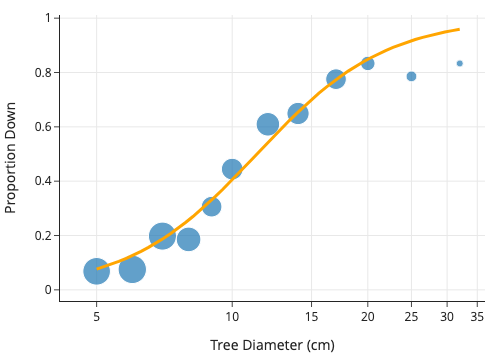

In [22]:
X_plt = np.expand_dims(np.linspace(X.min(), X.max(), 50),1)
p_hats = lr_model.predict_proba(X_plt)
X_orig = np.exp(X_plt)


fig = px.scatter(tree_bins, x='diameter', y='proportion', size='count', log_x=True,
        labels={'diameter':"Tree Diameter (cm)", 'proportion':"Proportion Down"},
        width=450, height=250)

fig.add_trace(go.Scatter(x=X_orig.flatten(), y=p_hats[:,1],
                         line=dict(color="orange", width=3)))

fig.update_layout(showlegend=False)              
fig

The curve follows the proportions reasonably well. In fact, we selected this particular logistic by fitting it to the data. To do this, we chose a loss function and minimized the average loss for our data with respect to the model parameters. Our choice of loss function is the topic of the next section. 

## Log Odds
            
The logistic model is also called the *log odds* model because the logistic function coincides with a linear function of the log odds. We can see this in the following equations. First we multiply the numerator and denominator of the sigmoid function by $\exp(t)$ 

$$
\begin{aligned}
p(t) & = \frac{1}{1+\exp(-t)} = \frac{\exp(t)}{1+\exp(t)} \\ 
\\
(1-p(t)) & = 1 - \frac{\exp(t)}{1+\exp(t)} = \frac{1}{1+\exp(t)}
\end{aligned}
$$

Then, we take the logarithm of the odds, $p / (1-p)$ and simplify:

$$
\begin{aligned}
\log \left( \frac{p(t)}{1-p(t)} \right) & = \log(\exp{(t)}) = t\\
\end{aligned}
$$

One last note is that the $\log$ function that we use here is the natural logarithm. 
The natural log is the default in data science and so we don't bother with writing it as $\ln$.



In [23]:
from sklearn.linear_model import LogisticRegression

X = trees[['diameter']].to_numpy()
y = trees['status_0_1'].to_numpy()

lr_model = LogisticRegression(solver="lbfgs")
lr_model.fit(X, y)

LogisticRegression()

In [24]:
lr_model.coef_

array([[0.3]])

In [25]:
lr_model.intercept_

array([-3.53])

In [26]:
1/(1 + np.exp(3.53 - (0.3*6)))

0.15058757974584394

In [28]:
1/(1 + np.exp(3.53 - (0.3*11)))

0.44275214540144436

In [32]:
np.exp(-3.53 + (0.3*6))

0.17728440996987782

In [34]:
np.exp(-3.53 + (0.3*11))

0.794533602503334

In [29]:
np.exp((0.3*5))

4.4816890703380645

The curve follows the proportions reasonably well. In fact, we selected this particular logistic by fitting it to the data. To do this, we chose a loss function and minimized the average loss for our data with respect to the model parameters. Our choice of loss function is the topic of the next section. 